In [2]:
%pip install PySimpleGUI

     ------------------------------------- 512.7/512.7 kB 16.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,'./modules')
from data_viewer import *
from duplicate_finder import *
from data_reader import *

from sklearn.metrics.pairwise import *
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import DistanceMetric

In [4]:
def get_ind(A, I, J):
    max_i, max_j = -1, -1
    max_val = -1e6
    for i in I:
        for j in J:
            val = A[i,j]
            if(val>max_val):
                max_val = val
                max_i, max_j = i, j
    return max_i, max_j


def VAT(D):
    n = D.shape[0]
    K = set(range(n))
    P = np.zeros((n,), dtype=int)
   
    #init
    i,_ = get_ind(D,K,K)
    P[0] = i
    I, J = set([i]), K - set([i])
    for r in range(1, n):
        i,j = get_ind(-D,I,J)
        P[r] = j
        I = I | set([j])
        J = J - set([j])
   
    D_new = np.zeros_like(D)
    for i in range(n):
        for j in range(n):
            D_new[i,j] = D[P[i],P[j]]
    return D_new


def make_remove_list(tuples, n_rows, start_row=3):
    remove = []
    for elem in tuples:
        if elem[0] not in remove:
            remove.append(elem[1])
    remove = np.unique(remove)
    keep = [i for i in range(n_rows) if i not in remove]
    
    return start_row + np.array(keep), start_row + remove

def tuples2list(tuples, start_row=3):
    result=np.zeros((2*len(tuples),))
    i=0
    for elem in tuples:
        result[i]=elem[0]
        result[i+1]=elem[1]
        i+=2
    return np.unique(result) + start_row

def unique(x, atol=0, rtol=0):
    if(tol==0):
        return np.unique(x, return_index=True, return_counts=True)
    n = x.shape[0]
    indices, counts = [], [] 
    for i in range(n-1):
        for j in range(i+1,n):
            pass

In [7]:
path = '../../PARKINSONS/PDproj/celldata/clean/'
filenames = [line.rstrip() for line in open(path +'filenames.txt')]
filenames

['cellshilicneg_log2.csv',
 'cellshilicpos_log2.csv',
 'cellsRPneg_log2.csv',
 'cellsRPpos_log2.csv',
 'cellslipidomicsneg_log2.csv',
 'cellslipidomicspos_log2.csv',
 'mediumHILICneg_log2.csv',
 'mediumHILICpos_log2.csv',
 'mediumRPneg_log2.csv',
 'mediumRPpos_log2.csv']

In [8]:
filenum = 4
file = filenames[filenum]
df=pd.read_csv(path+file, sep=';').iloc[2:,:]
df=df.iloc[np.argsort(np.asarray(df['Unnamed: 5'],dtype=float)),:]
data = read_file(file, path)
data.head()

,0,1,4,5,8,9,10,11,12,13,...,38,39,40,41,42,43,44,45,46,47
3,NaN,NaN,153.86851,0.612,20.5823628210225,21.0856252036358,20.817939266834,21.3206594422491,21.9587441879439,22.1137001683084,...,20.6582066085729,20.7239587603427,19.4995505425888,21.0663849289664,20.794783586534,20.7608171048475,21.0944156614195,21.3494060838718,20.3134213963495,21.250357643756
4,1H-Pentaphosphole,H5 P5,154.8687,0.614,17.51978469158,17.7472685961222,17.8293330247132,18.4159048713931,18.9727475457849,18.6685470278507,...,17.319966775744,17.9540723313268,16.3140300055871,17.8644900864232,17.5156998133476,17.4216425915922,17.6650569382784,18.3381907806332,17.2267268276863,18.4277927122068
5,Molybdenite,Mo S2,160.84197,0.611,22.0739438469012,22.3875188977663,22.0690509119235,22.7670948541284,22.168031144357,23.0348738431228,...,22.0226679054592,22.208892190553,21.7053681091064,22.2226011951588,22.4376531800592,22.3817173689247,23.2377348150125,22.3636660689927,22.10397013509,22.4620481015702
6,NaN,NaN,161.84979,0.608,18.2172377294134,18.4522913726107,18.2951615064631,18.4530081930699,18.3894957301928,18.6941078257804,...,18.3508655322929,18.3602318200596,17.3936433815841,18.6567038504014,18.6407207015155,18.4195791189119,18.9167158156346,18.5190422782117,18.541157731499,18.4237997306806
7,Carboselenoatoiron(1+),C Fe O Se,162.83902,0.613,22.0878330834146,22.3875188977663,22.0690509119235,22.6443438550231,22.4635751556908,22.9858765971225,...,21.9142278804991,22.2271862955958,21.6992871181389,22.2226011951588,22.3240151908216,22.3817173689247,22.4725116631508,22.3636660689927,22.1036195292107,22.464438973553


In [10]:
df.head(10)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,aSYN,aSYN.1,...,UT,UT.1,UT.2,UT.3,UT.4,UT.5,UT.6,UT.7,UT.8,UT.9
42,NaN,NaN,NaN,258.82653,257.81925,0.594,DDA for preferred ion,[M-H]-1,19.528828274683,19.5241256654289,...,19.8471188505997,19.4940767521217,19.5856697712571,19.734555010787,19.3299653763898,20.1138292365402,19.484998603295,19.0869845884795,19.9537704231716,19.129452133784
30,NaN,NaN,NaN,220.85269,219.84533,0.6,DDA for preferred ion,[M-H]-1,18.915080159661,18.7062467397909,...,19.1361269465176,18.7621964256323,19.1089992329265,19.0749876420292,18.7606196584225,19.176959736622,19.3065352422379,18.172913146602,19.3288361755274,18.4622208269347
5,NaN,NaN,NaN,162.85707,161.84979,0.608,DDA for preferred ion,[M-H]-1,18.2172377294134,18.4522913726107,...,18.3508655322929,18.3602318200596,17.3936433815841,18.6567038504014,18.6407207015155,18.4195791189119,18.9167158156346,18.5190422782117,18.541157731499,18.4237997306806
40,NaN,NaN,NaN,254.80104,253.79376,0.608,No MS2,[M-H]-1,17.7963043171567,18.1045172996353,...,17.6690362993301,18.3306865367068,17.1655650802946,18.0042782358796,17.9510915765063,17.7141191031876,18.114160034071,18.0693428766742,18.0606781701231,18.0406006382588
9,NaN,NaN,NaN,165.84327,164.83599,0.609,DDA for preferred ion,[M-H]-1,20.8670549111956,21.5403300522924,...,20.3418228862764,20.4777753861246,19.5007736607416,21.1413647962831,20.6805379852315,20.4837644507822,20.8077182260307,20.559178097209,20.4470195537896,21.7592959973552
20,Tetrachloro(hydrido)iron,H Cl4 Fe,0.36,196.81825,195.81097,0.609,DDA for preferred ion,[M-H]-1,25.714378778527,26.0597756798204,...,25.469539167324,25.882241931782,25.058677001424,25.8892391500337,25.9876951508045,25.8713940990299,26.2408264486673,26.0211022575552,25.7954990363863,26.0171724561134
26,NaN,NaN,NaN,210.84102,209.83374,0.61,DDA for preferred ion,[M-H]-1,19.6871213400051,19.9199422915662,...,19.6997920656247,19.8587475969355,19.4219382738293,20.1089538696061,20.0708438901568,20.2320763534373,20.363534920067,19.7624909381815,19.9970882707813,20.0533820033832
24,NaN,NaN,NaN,206.84684,205.83957,0.61,DDA for preferred ion,[M-H]-1,21.3741877143054,21.6503213444815,...,22.3539549831528,21.6489550321918,20.9254681706735,21.9299899758344,21.7374341476636,21.7679489293237,22.0590524792895,21.6541451864714,21.6368324320621,21.6880067439322
17,NaN,C H Cl2 N P2 S,2.52,190.86868,189.8614,0.61,DDA for preferred ion,[M-H]-1,18.8497219559889,19.9246252366873,...,18.2169465421997,18.9874359665964,17.0098469623436,19.6716208617048,19.2769145909245,19.2475211080043,19.727679491826,20.0958138303209,18.6042248132515,20.054259431005
4,Molybdenite,Mo S2,-1.89,161.84924,160.84197,0.611,DDA for preferred ion,[M-H]-1,22.0739438469012,22.3875188977663,...,22.0226679054592,22.208892190553,21.7053681091064,22.2226011951588,22.4376531800592,22.3817173689247,23.2377348150125,22.3636660689927,22.10397013509,22.4620481015702


### Group by RTime

- retention time can vary in the 1st decimal (in RP mode difference <=0.1min, in HILIC 0.2 or even 0.3)

In [11]:
data = pd.read_csv(path + file, sep=';', header=None).drop([0,1,2],axis=0).drop([2,3,6,7],axis=1)
data=data.iloc[np.argsort(np.asarray(data[4],dtype=float)),:]
data.index = range(data.shape[0])

In [12]:
RT=np.asarray(data[5],dtype=float)

In [13]:
D_RT=np.abs(RT[:,np.newaxis]-RT[np.newaxis,:])

In [14]:
np.sum(D_RT[6,:]<=0.01)

24

In [15]:
RT.shape[0]-np.unique(RT).shape[0]

214

In [16]:
vals, inds, counts=np.unique(RT, return_index=True, return_counts=True)

In [17]:
target=inds[np.where(counts>1)]

In [18]:
vals[np.where(counts>1)]

array([ 0.608,  0.609,  0.61 ,  0.611,  0.612,  0.613,  0.614,  0.619,
        0.68 ,  0.688,  0.697,  0.699,  0.705,  0.759, 13.855, 14.011,
       14.017, 14.019, 14.023, 14.109, 14.154, 14.191, 14.638, 14.639,
       14.64 , 14.652, 14.666, 14.806, 14.837, 14.841, 14.843, 14.896,
       14.953, 15.058, 15.153, 15.16 , 15.209, 15.232, 15.287, 15.288,
       15.291, 15.296, 15.298, 15.386, 15.412, 15.413, 15.434, 15.438,
       15.508, 15.509, 15.51 , 15.511, 15.513, 15.518, 15.542, 15.549,
       15.765, 15.776, 15.796, 15.801, 15.803, 15.862, 15.889, 15.89 ,
       15.948, 15.949, 15.95 , 15.954, 16.025, 16.077, 16.088, 16.103,
       16.114, 16.115, 16.131, 16.14 , 16.141, 16.143, 16.17 , 16.213,
       16.227, 16.336, 16.359, 16.369, 16.373, 16.374, 16.375, 16.377,
       16.449, 16.482, 16.485, 16.493, 16.501, 16.565, 16.579, 16.582,
       16.618, 16.695, 16.762, 16.764, 16.765, 16.807, 16.825, 16.826,
       16.893, 17.037, 17.05 , 17.07 , 17.082, 17.107, 17.11 , 17.111,
      

In [19]:
k=18
clust=data.iloc[np.where(RT==RT[target[k]])[0],4:].to_numpy(dtype=float)
np.corrcoef(clust)

array([[1.        , 0.78091424],
       [0.78091424, 1.        ]])

### ------------------------------------------------------------------------------------------------------------

In [20]:
indices1, mt_pairs1 = get_VAL_duplicates(data, 0.4)
indices2, mt_pairs2 = get_MT_duplicates(data,0.002,0.1)

In [21]:
keep=tuples2list(indices2,0)

In [22]:
deltamass=np.asarray(df.iloc[keep,2],dtype=float)

In [23]:
tmp=np.where(np.abs(deltamass)>1000)[0]
df_tmp=df.iloc[keep,:].iloc[tmp,:].sort_values(by='Unnamed: 4')
x=df_tmp.iloc[:,8:].to_numpy(dtype=float)
x.shape

(2, 40)

(array([ 2.,  0.,  1.,  1.,  3.,  5.,  5.,  3.,  9., 11.]),
 array([19.19419749, 19.71946652, 20.24473555, 20.77000458, 21.29527361,
        21.82054264, 22.34581167, 22.8710807 , 23.39634973, 23.92161876,
        24.44688779]),
 <BarContainer object of 10 artists>)

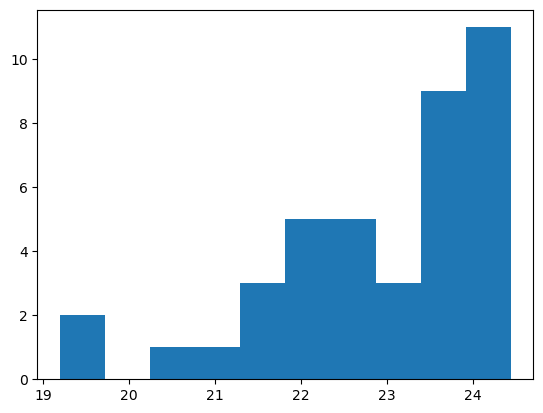

In [26]:
plt.hist(x[1,:])

In [27]:
df.iloc[keep,:].sort_values(by='Unnamed: 4').head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,aSYN,aSYN.1,...,UT,UT.1,UT.2,UT.3,UT.4,UT.5,UT.6,UT.7,UT.8,UT.9
1046,NaN,C53 H81 N6 O8 P3,-0.01,1022.53286,1021.52559,14.701,DDA for preferred ion,[M-H]-1,19.2544749972045,18.9961188348076,...,19.1250447755396,18.8907689621151,18.9355459505192,19.0676192428005,18.6751411716769,18.3389310527108,18.1209856022948,17.6341214016422,18.7918444445282,18.3573395331641
1050,NaN,C61 H88 O14 S,0.36,1076.58987,1075.58259,11.209,DDA for preferred ion,[M-H]-1,18.7314425800189,17.1569826802447,...,18.5186356708403,18.9360812503015,18.9105793309096,18.9274936242928,18.2718600930237,18.3016131244867,18.7752049322136,18.9694843105727,18.6419619672226,18.5300440110003
1052,NaN,C64 H97 N8 O7 P,0.21,1120.72202,1119.71475,13.325,DDA for preferred ion,[M-H]-1,18.9592853036135,17.4633455110927,...,18.8733856384592,18.8679489200249,19.0667366752525,19.0574566663068,18.7439523447167,18.7909403932341,19.0306018180765,19.0069911910734,18.7088104964984,19.1728201262102
1056,NaN,NaN,NaN,1174.76861,1173.76133,15.287,DDA for preferred ion,[M-H]-1,23.0456722796622,21.7171113979061,...,22.9951486738712,23.3484933192425,23.4861793106115,23.6101485915475,23.1916172164523,23.1721651675413,23.4543679871213,23.5251437535782,23.216927019916,23.3255719619259
1059,Irganox 1010,C73 H108 O12,0.57,1176.78474,1175.77747,15.199,DDA for preferred ion,[M-H]-1,23.0370776204553,21.7171113979061,...,22.9951486738712,23.3484933192425,23.4861793106115,23.6101485915475,23.1895300796383,23.1721651675413,23.4543679871213,23.5251437535782,23.216927019916,23.3255719619259


In [28]:
keep, remove=make_remove_list(indices1, data.shape[0],0)
X_purged = data.iloc[keep,4:].to_numpy(dtype=float).T
X_orig = data.iloc[:,4:].to_numpy(dtype=float).T

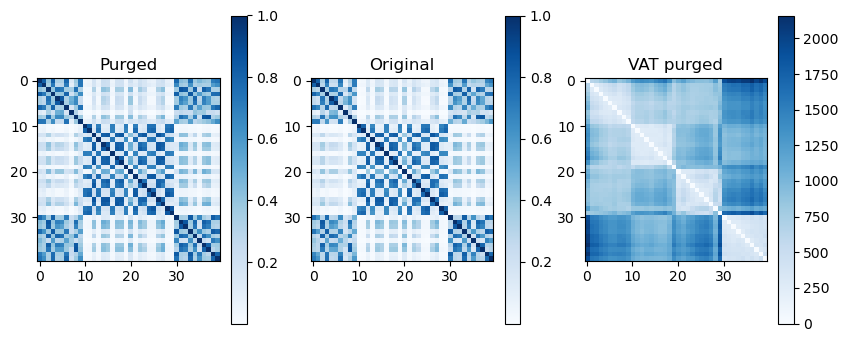

In [29]:
kernel = lambda x: rbf_kernel(x,gamma=0.001)
dist = lambda x, metric: pairwise_distances(x, metric=metric)

S1 = kernel(X_purged)
S2 = kernel(X_orig)
S3 = VAT(dist(X_purged,'manhattan'))
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 4), ncols=3)

pos1 = ax1.imshow(S1, cmap='Blues', interpolation='none')
fig.colorbar(pos1, ax=ax1)
ax1.set_title('Purged')

pos2 = ax2.imshow(S2, cmap='Blues', interpolation='none')
fig.colorbar(pos2, ax=ax2)
ax2.set_title('Original')

pos3 = ax3.imshow(S3, cmap='Blues', interpolation='none')
fig.colorbar(pos3, ax=ax3)
ax3.set_title('VAT purged')
plt.show()

In [30]:
pca_orig = PCA(n_components=10).fit_transform(X_orig)
pca_purged = PCA(n_components=10).fit_transform(X_purged)

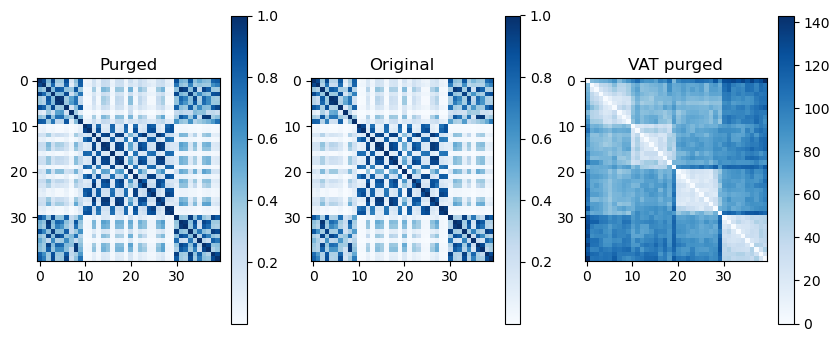

In [31]:
kernel = lambda x: rbf_kernel(x,gamma=0.001)
dist = lambda x, metric: pairwise_distances(x, metric=metric)

S1 = kernel(pca_purged)
S2 = kernel(pca_orig)
S3 = VAT(dist(pca_purged,'manhattan'))
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 4), ncols=3)

pos1 = ax1.imshow(S1, cmap='Blues', interpolation='none')
fig.colorbar(pos1, ax=ax1)
ax1.set_title('Purged')

pos2 = ax2.imshow(S2, cmap='Blues', interpolation='none')
fig.colorbar(pos2, ax=ax2)
ax2.set_title('Original')

pos3 = ax3.imshow(S3, cmap='Blues', interpolation='none')
fig.colorbar(pos3, ax=ax3)
ax3.set_title('VAT purged')
plt.show()

In [32]:
k=2
kmeans_orig = KMeans(n_clusters=k).fit(pca_orig)
kmeans_pruned = KMeans(n_clusters=k).fit(pca_purged)

C:\Users\paavo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\paavo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\paavo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\paavo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

Text(0.5, 1.0, 'Ground truth')

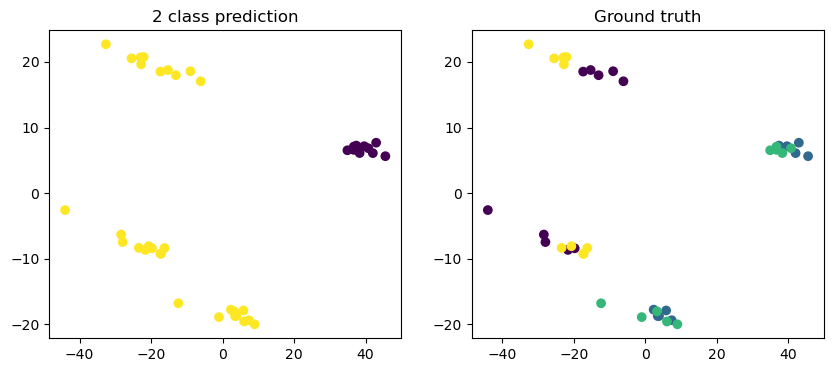

In [33]:
el1,el2=0,1
labels=np.array([np.ones((10,)),2*np.ones((10,)),3*np.ones((10,)),4*np.ones((10,))])
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(pca_orig[:,el1],pca_orig[:,el2],c=kmeans_orig.predict(pca_orig))
plt.title('2 class prediction')
plt.subplot(1,2,2)
plt.scatter(pca_orig[:,el1],pca_orig[:,el2],c=labels)
plt.title('Ground truth')

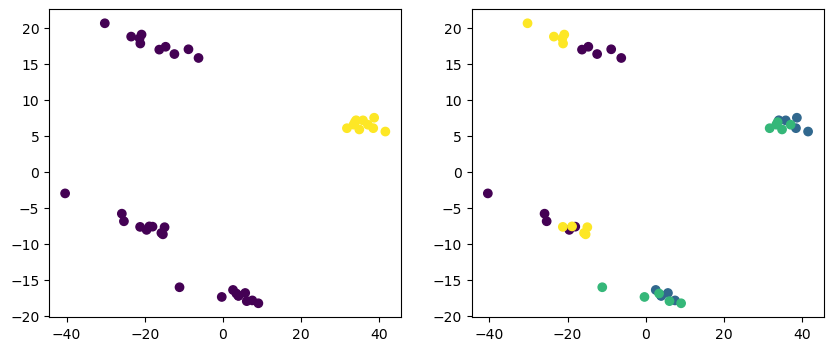

In [34]:
el1,el2=0,1
labels=np.array([np.ones((10,)),2*np.ones((10,)),3*np.ones((10,)),4*np.ones((10,))])
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(pca_purged[:,el1],pca_purged[:,el2],c=kmeans_pruned.predict(pca_purged))
plt.subplot(1,2,2)
plt.scatter(pca_purged[:,el1],pca_purged[:,el2],c=labels)

SIMILARITY: 0.825
----------------
nan
nan
686.47723
13.752
----------------
nan
C40 H69 N3 O2 S2
686.47726
13.754
----------------



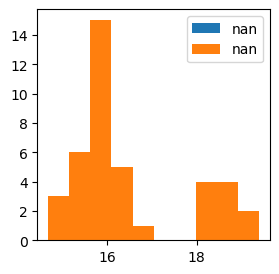

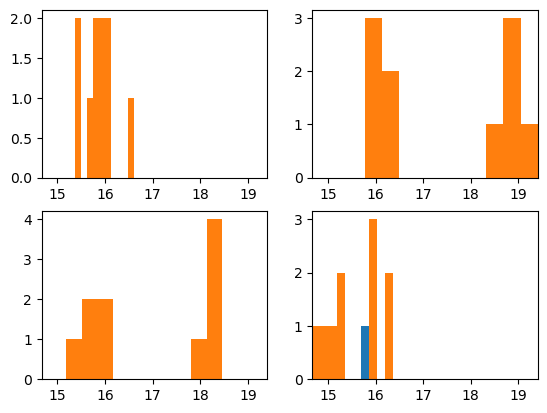

In [35]:
x=indices2
k=29
a,b=array_pair(data, x[k])
plt.figure(figsize=(3,3))
report_pair(a,b,x[k],data)
group_hist(a,b)

In [36]:
for i,elem in enumerate(mt_pairs1):
    print(str(i) + ': ' + elem[0] + ' - ' + elem[1])

0: 161.84979@0.608 - 163.84687@0.611
1: 225.06159@0.643 - 225.06161@0.635
2: 384.93548@0.699 - 384.93555@0.703
3: 459.32711@11.395 - 459.32715@11.401
4: 485.27297@14.015 - 485.27301@14.019
5: 548.50494@17.443 - 548.50495@17.448
6: 548.50495@17.639 - 548.50497@17.639
7: 554.47899@14.876 - 554.479@14.874
8: 572.48166@16.374 - 572.48167@16.373
9: 574.49736@16.893 - 574.49737@16.893
10: 582.51063@16.373 - 582.51063@16.376
11: 582.51063@16.373 - 582.51068@16.415
12: 582.51063@16.376 - 582.51068@16.415
13: 584.52625@16.891 - 584.52628@16.894
14: 596.56261@18.737 - 596.56271@18.741
15: 599.50082@16.377 - 599.50082@16.375
16: 610.54176@17.686 - 610.54185@17.687
17: 646.48215@15.691 - 646.48224@15.69
18: 650.49817@16.369 - 650.49819@16.374
19: 652.51394@16.886 - 652.51403@16.887
20: 662.47713@14.948 - 662.4772@14.945
21: 664.58921@18.786 - 664.58929@18.79
22: 672.49814@15.834 - 672.49819@15.819
23: 674.51338@17.037 - 674.51346@17.04
24: 674.51349@16.051 - 674.51364@15.992
25: 676.5291@17.223 - 

In [37]:
for i,elem in enumerate(mt_pairs2):
    print(str(i) + ': ' + elem[0] + ' - ' + elem[1])

0: 225.06159@0.643 - 225.06161@0.635
1: 384.93548@0.699 - 384.93555@0.703
2: 459.32711@11.395 - 459.32715@11.401
3: 480.27315@3.524 - 480.27324@3.542
4: 485.27297@14.015 - 485.27301@14.019
5: 548.50494@17.443 - 548.50495@17.448
6: 548.50495@17.639 - 548.50497@17.639
7: 554.47899@14.876 - 554.479@14.874
8: 572.48166@16.374 - 572.48167@16.373
9: 574.49736@16.893 - 574.49737@16.893
10: 582.51063@16.373 - 582.51063@16.376
11: 582.51063@16.373 - 582.51068@16.415
12: 582.51063@16.376 - 582.51068@16.415
13: 584.52625@16.891 - 584.52628@16.894
14: 596.56261@18.737 - 596.56271@18.741
15: 599.50082@16.377 - 599.50082@16.375
16: 610.54176@17.686 - 610.54185@17.687
17: 646.48215@15.691 - 646.48224@15.69
18: 649.51426@16.974 - 649.51428@16.967
19: 650.49817@16.369 - 650.49819@16.374
20: 652.51394@16.886 - 652.51403@16.887
21: 662.47713@14.948 - 662.4772@14.945
22: 664.58921@18.786 - 664.58929@18.79
23: 666.5102@14.801 - 666.51021@14.806
24: 672.49814@15.834 - 672.49819@15.819
25: 674.51338@17.037 -